In [20]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
import copy
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from utils.losses import EnergyScore, KernelScore, VariogramScore
from models.fno import FNO
from models.uno import UNO
from models.pfno import PNO_Wrapper, PFNO
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import DarcyFlowDataset
import cmcrameri

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loader for best predictions

In [21]:
batch_size = 32
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

In [80]:
data_dir = "../../data/DarcyFlow/processed/"
train_data = DarcyFlowDataset(data_dir, test = False, downscaling_factor=2)
test_data = DarcyFlowDataset(data_dir, test = True)

# Get domain and range
x,y = test_data.get_coordinates()
L = test_data.get_domain_range()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

n_train = len(train_loader)
n_test = len(test_loader)

In [24]:
path = "../../results/darcy_flow_test_results/"

dropout_model = FNO(n_modes=(12,12), hidden_channels=32, in_channels = 3,dropout=0.05)

base_model_cp = torch.load(path+"dropout.pt", map_location=torch.device("cpu"))
dropout_model.load_state_dict(base_model_cp)

laplace_cp = torch.load(path+"laplace.pt", map_location=torch.device("cpu"))
laplace_model = copy.deepcopy(dropout_model)
laplace_model.load_state_dict(laplace_cp)
la_model = LA_Wrapper(laplace_model)
#la_model.fit(train_loader)

pfno_model = PFNO(n_modes=(12,12), hidden_channels=32, in_channels = 3,dropout=0.05)
pfno_cp = torch.load(path+"sr_reparam.pt", map_location=torch.device("cpu"))
pfno_model.load_state_dict(pfno_cp)



<All keys matched successfully>

# Predictions

In [25]:
samples = np.random.randint(0,n_test,5)

pfno_model.train()
dropout_model.train()
""" Prediction """
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)
        #la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )
        #pred_la.append( la_pred )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
# Plot function should get
# truth, predictions of one sample, names, grid, and save_path

In [127]:
def plot_statistics(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid

    fig, axs = plt.subplots(n_models, 3, figsize = (12, 8))
    for m, pred in enumerate(preds):
            truth = truth.squeeze()
            pred = pred.squeeze()
            # Calculate coverage
            q_lower = np.quantile(pred,alpha/2, axis = -1)
            q_upper = np.quantile(pred,1-alpha/2, axis = -1)
            coverage = (truth>q_lower) & (truth<q_upper)
            axs[m,0].pcolormesh(x,y,truth - pred.mean(axis = -1), shading = "nearest", cmap = "cmc.batlow")
            axs[m,1].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla")
            axs[m,2].pcolormesh(x,y,coverage, shading = "nearest")
            axs[m,0].set_ylabel(names[m])

    for m in range(n_models):
         for i in range(1,3):
              axs[m,i].set_yticks([])
    for i in range(3):
        axs[0,i].set_xticks([])     

    axs[0,0].set_title('Mean error')
    axs[0,1].set_title('Standard deviation')
    axs[0,2].set_title('Coverage (95%)')
    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)
    
    plt.show()

In [128]:
def plot_predictions(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid

    fig, axs = plt.subplots(n_models, 4, figsize = (12, 8))
    for m, pred in enumerate(preds):
            truth = truth.squeeze()
            pred = pred.squeeze()
            axs[m,0].pcolormesh(x,y,truth, shading = "nearest", cmap = "cmc.batlow")
            axs[m,1].pcolormesh(x,y,pred.mean(axis = -1), shading = "nearest", cmap = "cmc.batlow")
            axs[m,2].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla")
            # Calculate coverage
            q_lower = np.quantile(pred,alpha/2, axis = -1)
            q_upper = np.quantile(pred,1-alpha/2, axis = -1)
            coverage = (truth>q_lower) & (truth<q_upper)
            axs[m,3].pcolormesh(x,y,coverage, shading = "nearest")
            axs[m,0].set_ylabel(names[m])

    for m in range(n_models):
         for i in range(1,4):
              axs[m,i].set_yticks([])
    for i in range(4):
        axs[0,i].set_xticks([])     


    axs[0,0].set_title('Ground truth')
    axs[0,1].set_title('Mean prediction')
    axs[0,2].set_title('Standard deviation')
    axs[0,3].set_title('Coverage (95%)')
    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)
    
    plt.show()

# Plot

In [129]:
idx = 0

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

preds = [pred_dropout[idx],pred_pfno[idx]]
names = ['Dropout','PFNO']

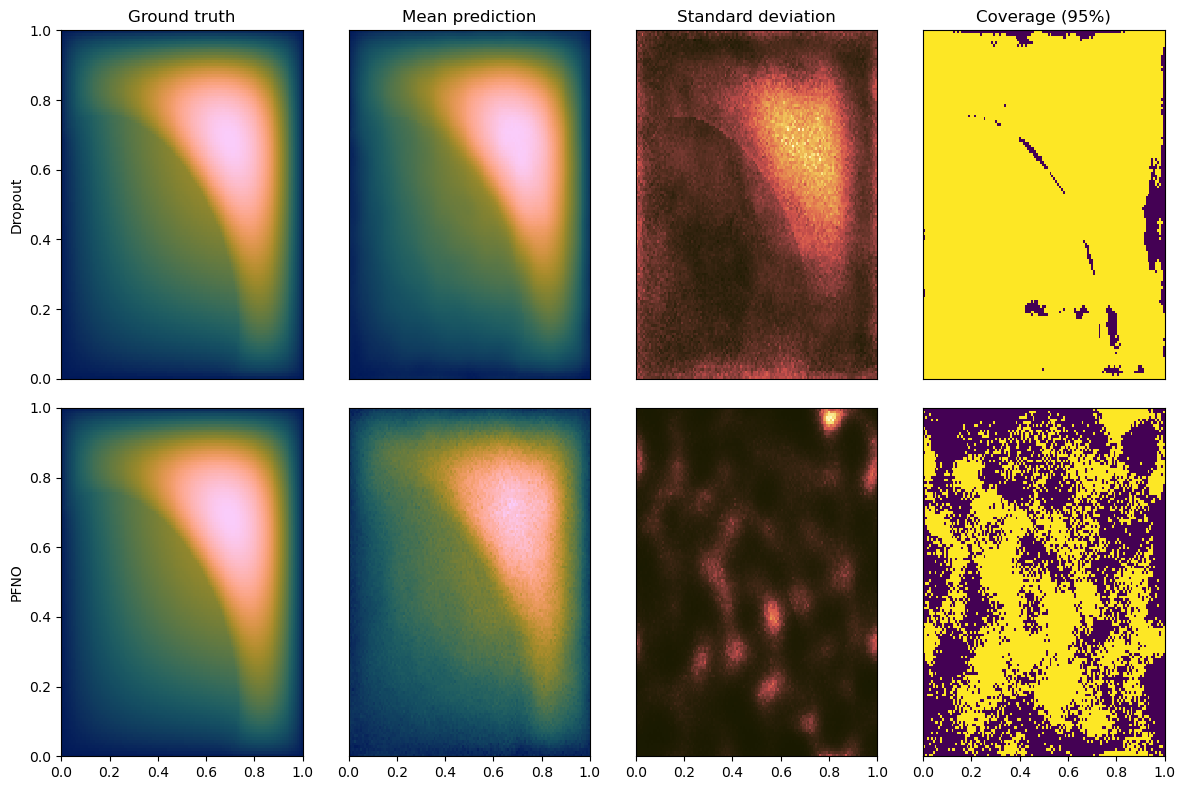

In [130]:
plot_predictions(u, preds, names, (x,y))

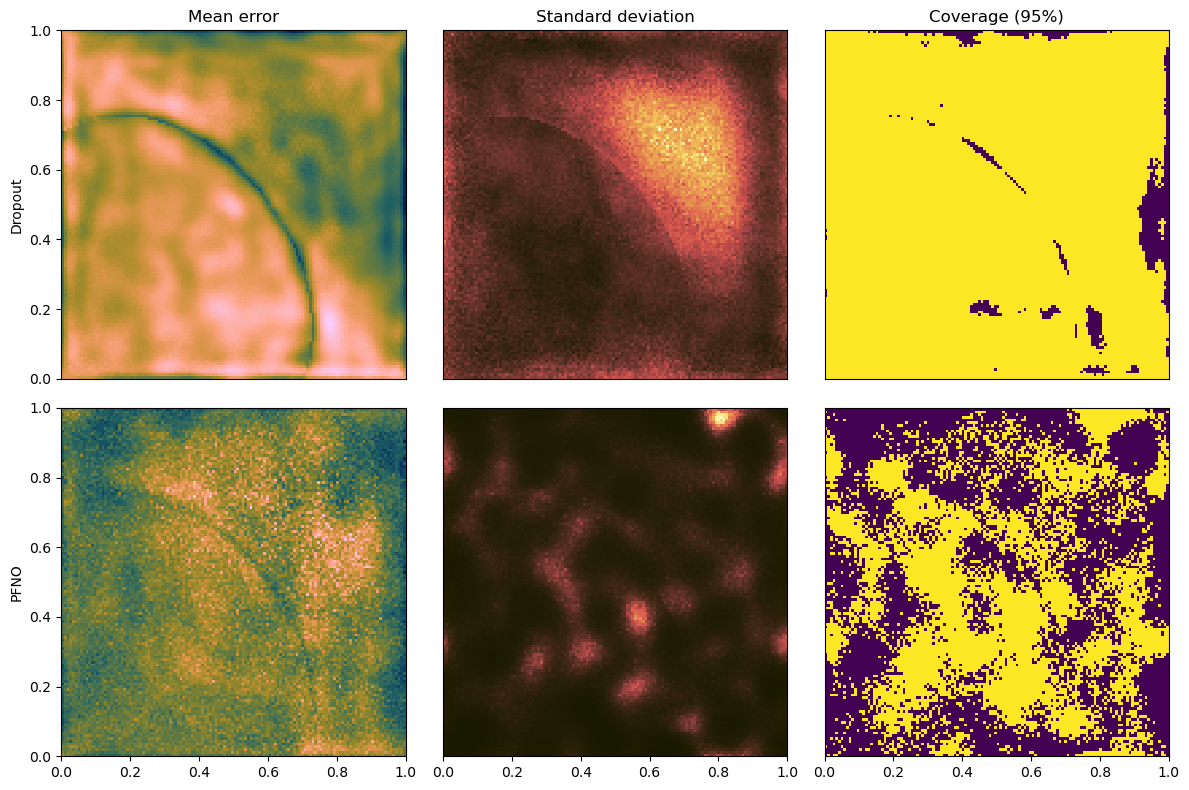

In [131]:
plot_statistics(u, preds, names, (x,y))